## Installations

In [1]:
pip install xgboost


/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by bash)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by bash)
Note: you may need to restart the kernel to use updated packages.


## Imports

In [3]:
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import shap
from sklearn.preprocessing import MinMaxScaler

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Loading Datasets

In [4]:
# Loading patient population dataset
pop =pd.read_csv('/project/ppopulation.csv')
# Loading NICE TA dates dataset
dates = pd.read_csv('/project/NICE TA Dates.csv')
# Loading product bridging dataset
product = pd.read_excel('/project/Product Bridging.xlsx')
# Loading deprivation indices dataset
dep = pd.read_excel('/project/dep2.xlsx',sheet_name='Rankings for all indicators',skiprows=1)
# Loading Formulytics dataset
fl = pd.read_csv('/project/TAB - Report Data.csv', encoding='latin-1')

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.


## Data Cleaning

In [5]:
#Removing Unrelated Columns
fl.drop(columns=['Chapter', 'SubChapter', 'ChapterName','SubChapterName','GP Rx Description'], inplace=True)

In [6]:
#Renaming column for consistency
product = product.rename(columns={'ShortnameCode': 'ShortNameCode'})

Checking how the POSTCODE looks like in the patient population dataset

In [7]:
pop.head()

,PUBLICATION,EXTRACT_DATE,TYPE,SUB_ICB_LOCATION_CODE,ONS_SUB_ICB_LOCATION_CODE,CODE,POSTCODE,SEX,AGE,NUMBER_OF_PATIENTS
0,GP_PRAC_PAT_LIST,01Apr2023,GP,00L,E38000130,A84002,NE65 7UW,ALL,ALL,6078
1,GP_PRAC_PAT_LIST,01Apr2023,GP,00L,E38000130,A84005,NE22 6JX,ALL,ALL,12256
2,GP_PRAC_PAT_LIST,01Apr2023,GP,00L,E38000130,A84006,NE66 2NL,ALL,ALL,18846
3,GP_PRAC_PAT_LIST,01Apr2023,GP,00L,E38000130,A84007,NE20 9SD,ALL,ALL,10799
4,GP_PRAC_PAT_LIST,01Apr2023,GP,00L,E38000130,A84008,NE70 7ER,ALL,ALL,4510


Checking what F_POSTCODE looks like in the Formulytics dataset

In [8]:
fl.head()

,ID,FORMULARY_ID,Formulary Followed,Formulary_URL,Formulary Type,Formulary Status,F_POSTCODE,F GPO Post Code District,Date Joined,Date Left,...,Indication,Paediatric Use,Status,Date AI Changed,Date Status Changed,Rx Details,Rx Initiator,Rx Position,Availability Index,Comments Restriction
0,1,1,3Ts,http://www.gwh.nhs.uk/patients-and-visitors/ph...,Joint Formulary,Inactive,SN25,SN25,NaN,2019-09-10,...,T2,0,Active,2019-01-30,2019-01-30,NaN,All Physicians,1,100.0,NaN
1,2,1,3Ts,http://www.gwh.nhs.uk/patients-and-visitors/ph...,Joint Formulary,Inactive,SN25,SN25,NaN,2019-09-10,...,None specified,0,Comments Change,2016-05-06,2019-01-30,Please note Insuman basal® is the first line i...,All Physicians,1,100.0,NaN
2,3,1,3Ts,http://www.gwh.nhs.uk/patients-and-visitors/ph...,Joint Formulary,Inactive,SN25,SN25,NaN,2019-09-10,...,T2,0,Active,2019-01-30,2019-01-30,(if available).,All Physicians,1,100.0,NaN
3,4,1,3Ts,http://www.gwh.nhs.uk/patients-and-visitors/ph...,Joint Formulary,Inactive,SN25,SN25,NaN,2019-09-10,...,T2,0,Active,2019-01-30,2019-01-30,(if available).,All Physicians,1,100.0,NaN
4,5,1,3Ts,http://www.gwh.nhs.uk/patients-and-visitors/ph...,Joint Formulary,Inactive,SN25,SN25,NaN,2019-09-10,...,T2,0,Active,2016-05-06,2019-01-30,(if available).,All Physicians,1,100.0,NaN


Cleaning to merge the datasets

In [9]:
# Splitting the 'postcode' column into two columns based on space
pop[['F_POSTCODE', 'Second_Part']] = pop['POSTCODE'].str.split(' ', 1, expand=True)

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.


In [10]:
# Grouping by 'F_POSTCODE' and summing the 'Number_of_Patients'
patients_by_postcode = pop.groupby('F_POSTCODE')['NUMBER_OF_PATIENTS'].sum().reset_index()

In [11]:
# Merging the two tables based on a common column
dates = dates.merge(product[['ShortNameCode', 'ProductGroupCode','ProductGroup']], on='ShortNameCode', how='left')

Checking the size of the datasets

In [12]:
dates.shape

(795, 12)

In [13]:
fl.shape

(1354721, 43)

Merging Product Group with formulary data:

In [14]:
#renaming the column
product = product.rename(columns={'ShortNameCode': 'Short Name Code'})

In [15]:
fl = fl.merge(product[['Short Name Code', 'ProductGroupCode','ProductGroup']], on='Short Name Code', how='left')

In [16]:
fl.shape

(1527681, 45)

### Change the date types

In [17]:
#checking the data types
fl.dtypes

ID                             int64
FORMULARY_ID                   int64
Formulary Followed            object
Formulary_URL                 object
Formulary Type                object
Formulary Status              object
F_POSTCODE                    object
F GPO Post Code District      object
Date Joined                   object
Date Left                     object
Org to Formulary Status       object
ORG_ID                         int64
Organisation Name             object
NHS Code                      object
Organisation Type             object
Org Status                    object
ORG_POSTCODE                  object
Org GPO PostCode District     object
Market_ID                      int64
Market                        object
Class_ID                     float64
Class                         object
Short Name Code               object
Short Name                    object
Presentation Code             object
Product Detail                object
Presentation                  object
S

In [18]:
# Converting columns to date types
date_columns = ["Date Joined", "Date Left", "Date AI Changed", "Date Status Changed"]
fl[date_columns] = fl[date_columns].apply(pd.to_datetime)

In [19]:
fl.dtypes

ID                                    int64
FORMULARY_ID                          int64
Formulary Followed                   object
Formulary_URL                        object
Formulary Type                       object
Formulary Status                     object
F_POSTCODE                           object
F GPO Post Code District             object
Date Joined                  datetime64[ns]
Date Left                    datetime64[ns]
Org to Formulary Status              object
ORG_ID                                int64
Organisation Name                    object
NHS Code                             object
Organisation Type                    object
Org Status                           object
ORG_POSTCODE                         object
Org GPO PostCode District            object
Market_ID                             int64
Market                               object
Class_ID                            float64
Class                                object
Short Name Code                 

In [20]:
fl.describe()

,ID,FORMULARY_ID,ORG_ID,Market_ID,Class_ID,Brand,Paediatric Use,Rx Position,Availability Index
count,1.527681e+06,1.527681e+06,1.527681e+06,1.527681e+06,1.527109e+06,1.527681e+06,1.527681e+06,1.527681e+06,1.527468e+06
mean,6.798016e+05,1.458740e+02,6.412722e+02,1.066536e+01,5.490105e+01,5.662583e-01,6.450954e-02,2.257605e-01,5.344214e+01
std,3.912005e+05,8.544998e+01,3.080255e+02,1.193246e+01,4.792174e+01,4.955906e-01,2.456585e-01,6.040473e-01,3.330560e+01
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.426790e+05,7.100000e+01,4.390000e+02,3.000000e+00,2.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.500000e+01
50%,6.812040e+05,1.540000e+02,6.260000e+02,4.000000e+00,3.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00,4.500000e+01
75%,1.018626e+06,2.040000e+02,8.990000e+02,1.200000e+01,7.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02
max,1.354721e+06,3.170000e+02,1.194000e+03,3.900000e+01,1.800000e+02,1.000000e+00,1.000000e+00,9.000000e+00,1.000000e+02


In [21]:
fl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1527681 entries, 0 to 1527680
Data columns (total 45 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   ID                         1527681 non-null  int64         
 1   FORMULARY_ID               1527681 non-null  int64         
 2   Formulary Followed         1527681 non-null  object        
 3   Formulary_URL              1527035 non-null  object        
 4   Formulary Type             1527681 non-null  object        
 5   Formulary Status           1527681 non-null  object        
 6   F_POSTCODE                 1527667 non-null  object        
 7   F GPO Post Code District   1527667 non-null  object        
 8   Date Joined                491191 non-null   datetime64[ns]
 9   Date Left                  641775 non-null   datetime64[ns]
 10  Org to Formulary Status    1527681 non-null  object        
 11  ORG_ID                     1527681 no

In [22]:
fl.isnull().sum()

ID                                 0
FORMULARY_ID                       0
Formulary Followed                 0
Formulary_URL                    646
Formulary Type                     0
Formulary Status                   0
F_POSTCODE                        14
F GPO Post Code District          14
Date Joined                  1036490
Date Left                     885906
Org to Formulary Status            0
ORG_ID                             0
Organisation Name                  0
NHS Code                       32845
Organisation Type                  0
Org Status                         0
ORG_POSTCODE                    2160
Org GPO PostCode District       2160
Market_ID                          0
Market                             0
Class_ID                         572
Class                            572
Short Name Code                    0
Short Name                         0
Presentation Code             850057
Product Detail                     0
Presentation                  902971
S

In [23]:
fl = fl.rename(columns={'Short Name Code': 'ShortNameCode'})

In [24]:
dates.dtypes

NICETAID            object
Title               object
DatePublished       object
DateUpdated         object
DateRemoved         object
ShortNameCode       object
ShortName           object
VBIndication        object
FastTracked          int64
URL                 object
ProductGroupCode    object
ProductGroup        object
dtype: object

In [25]:
date_columns = ["DateUpdated", "DatePublished", "DateRemoved"]
dates[date_columns] = dates[date_columns].apply(pd.to_datetime)

In [26]:
dates = dates.rename(columns={'VBIndication': 'Indication'})

In [27]:
dates.shape

(795, 12)

In [28]:
fl.shape

(1527681, 45)

### Merging the datasets

In [29]:
merged_data = fl.merge(dates[['DatePublished','FastTracked','ProductGroupCode']], on='ProductGroupCode',how='inner')

In [30]:
merged_data.shape

(5080230, 47)

In [31]:
patients_by_postcode.reset_index(drop=True, inplace=True)

In [32]:
merged_data = merged_data.merge(patients_by_postcode[['NUMBER_OF_PATIENTS','F_POSTCODE']], on='F_POSTCODE')

also what to do with minus duration??

### Rows to delete
- inactive formulary
- inactive org-formulary
- inactive org
- 15 and less Availability index

### Removing Inactive Status

In [33]:
merged_data['Formulary Status'].unique()

array(['Inactive', 'Active'], dtype=object)

In [34]:
merged_data = merged_data[merged_data['Formulary Status'] == 'Active']

In [35]:
merged_data['Org Status'].unique()

array(['Active', 'Inactive', 'Name changed'], dtype=object)

In [36]:
merged_data = merged_data[merged_data['Org Status'] == 'Active'] 

In [37]:
merged_data = merged_data[merged_data['Org to Formulary Status'] == 'Active'] 

### Filtering AI

In [38]:
filtered_data = merged_data[merged_data['Availability Index'] > 15.0]

In [39]:
filtered_data.shape

(2473108, 48)

### Calculating the earliest date AI changed for a certain medicine

In [40]:
filtered_data['Min_Date_AI_Changed'] = filtered_data.groupby(['ProductGroupCode'])['Date AI Changed'].transform('min')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
filtered_data.shape

(2473108, 49)

### Number of Partnered Organization Column Creation

In [42]:
# Grouping the DataFrame by 'Formulary ID' and count unique 'Org ID' values
org_count = filtered_data.groupby('FORMULARY_ID')['ORG_ID'].nunique()

# Creating a new column 'Org Count' in the DataFrame with the count values
filtered_data['Org_Count'] = filtered_data['FORMULARY_ID'].map(org_count)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


How many formularies are there?

In [43]:
filtered_data['FORMULARY_ID'].nunique()

166

how many organisations are there?

In [44]:
filtered_data['ORG_ID'].nunique()

284

how many products are there?

In [45]:
filtered_data['ProductGroup'].nunique()

180

### Calculating complete duration

In [46]:
filtered_data['Duration'] = filtered_data['Min_Date_AI_Changed'] - filtered_data['DatePublished']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
filtered_data = filtered_data[['FORMULARY_ID','Brand', 'Formulary Followed', 'Formulary Type','F_POSTCODE','ProductGroup','Market','Presentation','Strength','Paediatric Use','FastTracked', 'NUMBER_OF_PATIENTS',
'Org_Count', 'Duration']]

In [48]:
filtered_data = filtered_data.drop_duplicates()

In [49]:
filtered_data.shape

(64005, 14)

### Creating city column

In order to create a region column we have to create a city column first.

In [50]:
# Creating a dictionary mapping postcodes to city names
postcode_to_city = {
    'SA12': 'Port Talbot',
    'KT16': 'Chertsey',
    'KA6': 'Ayr',
    'RM7': 'Romford',
    'E1': 'London',
    'LL57': 'Bangor',
    'B15': 'Birmingham',
    'BD9': 'Bradford',
    'FY3': 'Blackpool',
    'BS1': 'Bristol',
    'HP7': 'High Wycombe',
    'NW1': 'London',
    'M13': 'Manchester',
    'CV2': 'Coventry',
    'DE22': 'Derby',
    'CF45': 'Mountain Ash',
    'EX2': 'Exeter',
    'TQ2': 'Torquay',
    'DN2': 'Doncaster',
    'DY5': 'Brierley Hill',
    'FK5': 'Larbert',
    'GU16': 'Camberley',
    'SM5': 'Carshalton',
    'GL3': 'Gloucester',
    'G12': 'Glasgow',
    'IV2': 'Inverness',
    'HU10': 'Hull',
    'W2': 'London',
    'SA31': 'Carmarthen',
    'LE19': 'Leicester',
    'L14': 'Liverpool',
    'LU4': 'Luton',
    'ME4': 'Chatham',
    'CM16': 'Epping',
    'SW1E': 'London',
    'NN15': 'Kettering',
    'BT9': 'Belfast',
    'OX3': 'Oxford',
    'L3': 'Liverpool',
    'B18': 'Birmingham',
    'HX3': 'Halifax',
    'SW17': 'London',
    'SR5': 'Sunderland',
    'RH1': 'Redhill',
    'PE30': 'Kings Lynn',
    'CM20': 'Harlow',
    'DD1': 'Dundee',
    'IP33': 'Bury St Edmunds',
    'YO31': 'York',
    'SS14': 'Basildon',
    'WR3': 'Worcester',
    'JE1': 'St Helier',
    'NE29': 'North Shields',
    'BA21': 'Yeovil',
    'SE1': 'London',
    'UB8': 'Uxbridge',
    'DA12': 'Gravesend',
    'GU1': 'Guildford',
    'DL3': 'Darlington',
    'TN25': 'Ashford',
    'E16': 'London',
    'EH1': 'Edinburgh',
    'SK10': 'Macclesfield',
    'CW1': 'Crewe',
    'BD20': 'Keighley',
    'NP18': 'Newport',
    'S75': 'Barnsley',
    'B9': 'Birmingham',
    'CF5': 'Cardiff',
    'N1': 'London',
    'CR7': 'Thornton Heath',
    'BH12': 'Poole',
    'SG1': 'Stevenage',
    'BB2': 'Blackburn',
    'AB15': 'Aberdeen',
    'WC1N': 'London',
    'HG2': 'Harrogate',
    'AL8': 'Welwyn Garden City',
    'HU3': 'Hull',
    'PO30': 'Newport',
    'WS2': 'Walsall',
    'PR2': 'Preston',
    'NR31': 'Great Yarmouth',
    'LS15': 'Leeds',
    'HA1': 'Harrow',
    'MK3': 'Milton Keynes',
    'EC1V': 'London',
    'NR34': 'Beccles',
    'OX4': 'Oxford',
    'S9': 'Sheffield',
    'NR11': 'Cromer',
    'RM13': 'Rainham',
    'DN20': 'Brigg',
    'ST5': 'Newcastle-under-Lyme',
    'LD3': 'Brecon',
    'SY3': 'Shrewsbury',
    'RH19': 'East Grinstead',
    'SY10': 'Oswestry',
    'DE13': 'Burton-on-Trent',
    'M8': 'Manchester',
    'SK2': 'Stockport',
    'WA5': 'Warrington',
    'ME16': 'Maidstone',
    'GY6': 'Guernsey',
    'BA2': 'Bath',
    'SS16': 'Basildon',
    'NR7': 'Norwich',
    'KT1': 'Kingston upon Thames',
    'DN4': 'Doncaster',
    'SO50': 'Eastleigh',
    'BN13': 'Worthing',
    'CO4': 'Colchester',
    'LS9': 'Leeds',
    'NG34': 'Sleaford',
    'B70': 'West Bromwich',
    'S66': 'Rotherham',
    'B4': 'Birmingham',
    'S44': 'Chesterfield',
    'PL25': 'St Austell',
    'DG1': 'Dumfries',
    'NG3': 'Nottingham',
    'WV10': 'Wolverhampton',
    'RG1': 'Reading',
    'SW10': 'London',
    'CT1': 'Canterbury',
    'KY2': 'Kirkcaldy',
    'NN16': 'Kettering',
    'WF1': 'Wakefield',
    'LA9': 'Kendal',
    'BA22': 'Yeovil',
    'NR4': 'Norwich',
    'NN1': 'Northampton',
    'S10': 'Sheffield',
    'HP2': 'Hemel Hempstead',
    'OL6': 'Ashton-under-Lyne',
    'S60': 'Rotherham',
    'CB2': 'Cambridge',
    'G71': 'Glasgow',
    'NE2': 'Newcastle upon Tyne',
    'SW3': 'London',
    'SN15': 'Chippenham',
    'CH2': 'Chester',
    'AL3': 'St Albans',
    'IG3': 'Ilford',
    'ST16': 'Stafford',
    'UB2': 'Southall',
    'TD6': 'Melrose',
    'N15': 'London',
    'L34': 'Prescot',
    'NR6': 'Norwich',
    'KT22': 'Leatherhead',
    'SS11': 'Wickford',
    'BR3': 'Beckenham',
    'BD18': 'Shipley'
}
# Creating the 'City' column based on the 'F_POSTCODE' column
filtered_data['City'] = filtered_data['F_POSTCODE'].map(postcode_to_city)

### Creating region column

In [51]:
city_to_region = {
    'Chertsey': 'South East',
    'Romford': 'London',
    'London': 'London',
    'Birmingham': 'West Midlands',
    'Bradford': 'Yorkshire and The Humber',
    'Blackpool': 'North West',
    'Bristol': 'South West',
    'High Wycombe': 'South East',
    'Halifax': 'Yorkshire and The Humber',
    'Manchester': 'North West',
    'Chester': 'North West',
    'Colchester': 'East of England',
    'Coventry': 'West Midlands',
    'Thornton Heath': 'London',
    'Derby': 'East Midlands',
    'Exeter': 'South West',
    'Torquay': 'South West',
    'Brierley Hill': 'West Midlands',
    'Stevenage': 'East of England',
    'Camberley': 'South East',
    'Carshalton': 'London',
    'Gloucester': 'South West',
    'Welwyn Garden City': 'East of England',
    'Hull': 'Yorkshire and The Humber',
    'Walsall': 'West Midlands',
    'Kingston upon Thames': 'London',
    'Preston': 'North West',
    'Leicester': 'East Midlands',
    'Liverpool': 'North West',
    'Luton': 'East of England',
    'Chatham': 'South East',
    'Beccles': 'East of England',
    'Sheffield': 'Yorkshire and The Humber',
    'Shrewsbury': 'West Midlands',
    'Gravesend': 'South East',
    'Yeovil': 'South West',
    'Epping': 'East of England',
    'Eastleigh': 'South East',
    'Cromer': 'East of England',
    'Brigg': 'Yorkshire and The Humber',
    'North Shields': 'North East',
    'Newcastle-under-Lyme': 'West Midlands',
    'Kettering': 'East Midlands',
    'Oxford': 'South East',
    'East Grinstead': 'South East',
    'Basildon': 'East of England',
    'Sunderland': 'North East',
    'Redhill': 'South East',
    'Bath': 'South West',
    'Kings Lynn': 'East of England',
    'Harlow': 'East of England',
    'Bury St Edmunds': 'East of England',
    'Wolverhampton': 'West Midlands',
    'Worcester': 'West Midlands',
    'Uxbridge': 'London',
    'Guildford': 'South East',
    'Darlington': 'North East',
    'Ashford': 'South East',
    'Norwich': 'East of England',
    'Macclesfield': 'North West',
    'Harrow': 'London',
    'Crewe': 'North West',
    'Barnsley': 'Yorkshire and The Humber',
    'Poole': 'South West',
    'Blackburn': 'North West',
    'Harrogate': 'Yorkshire and The Humber',
    'Newport': 'South East',
    'Great Yarmouth': 'East of England',
    'Leeds': 'Yorkshire and The Humber',
    'Milton Keynes': 'South East',
    'Rainham': 'London',
    'Burton-on-Trent': 'West Midlands',
    'Oswestry': 'West Midlands',
    'Stockport': 'North West',
    'Warrington': 'North West',
    'Maidstone': 'South East',
    'Doncaster': 'Yorkshire and The Humber',
    'Sleaford': 'East Midlands',
    'West Bromwich': 'West Midlands',
    'Rotherham': 'Yorkshire and The Humber',
    'Chesterfield': 'East Midlands',
    'St Austell': 'South West',
    'Nottingham': 'East Midlands',
    'Hemel Hempstead': 'East of England',
    'Reading': 'South East',
    'Cambridge': 'East of England',
    'Canterbury': 'South East',
    'Wakefield': 'Yorkshire and The Humber',
    'Kendal': 'North West',
    'Northampton': 'East Midlands',
    'Ashton-under-Lyne': 'North West',
    'Newcastle upon Tyne': 'North East',
    'Chippenham': 'South West',
    'St Albans': 'East of England',
    'Ilford': 'London',
    'Stafford': 'West Midlands',
    'Southall': 'London',
    'Prescot': 'North West',
    'Leatherhead': 'South East',
    'Beckenham': 'London',
    'Shipley': 'Yorkshire and The Humber'
}
filtered_data['Region'] = filtered_data['City'].map(city_to_region)

In [52]:
filtered_data.Region.unique()

array(['South East', 'London', 'West Midlands',
       'Yorkshire and The Humber', 'North West', 'South West',
       'East of England', 'East Midlands', 'North East'], dtype=object)

### Strength Column

In [53]:
#checking the values of Strength
filtered_data.Strength.unique()

array(['6mg/3ml', nan, '100mg', '25mg', '30mg', '5mg', '10mg',
       '5mcg/0.02ml 1.2ml', '15mg', '50mg/0,5ml', '50mg/0.5ml',
       '100mg/ml', '45mg', '200mg', '150mg', '300mg', '80mg', '125mg',
       '250mg', '400mg', '20mg/ml', '150mg/ml', '500mcg', '10mg/ml',
       '5mg/5ml', '60mg', '2.5mg', '20mg', '75mg/0.5ml Pfs', '2mg', '4mg',
       '250mcg/ml', '75mg', '40mg/ml', '8mg', 'Pdr 50u Vl', 'Pdr 100u Vl',
       '200u', '284mg', '40mg', '90mg', '200mg/10ml', '120mg',
       '225mg/1.5ml', '140mg/1ml', '70mg/ml', '140mg', '100u Vl',
       '120mg/1ml', '97mg/103mg', '49mg/51mg', '24mg/26mg', '250mg/5ml',
       '125mg/1ml', '120mg/ml', '225mg', '110mg', '998mg', '0.05% 0.4ml',
       '50mcg/ml', '0.2%', '2mg/0.85ml', '130mg', '200mg/1.14ml',
       '150mg/1.14ml', '163mg/0.9ml', '150mg/1ml', '300mg/2ml',
       '300mg/ml', '100mg/1ml', '10mg S/F', '15mg S/F', '150mg/ml Pfs',
       '267mg', '210mg', '1.65mg/0.165ml', '180mg', '50u', '75mg/1ml',
       '180mg/10mg', '1000mg', '40

In [54]:
# Grouping by 'Market' and calculating the mode for 'Strength' in each group
mode_dose_by_market = filtered_data.groupby('Market')['Strength'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else 'default_value')

# Filling the null values in 'Strength' with the corresponding mode value for each 'Market'
filtered_data['Strength'].fillna(mode_dose_by_market, inplace=True)

In [55]:
# Creating a function to extract the dose unit from the dose
def extract_dose_unit(dose):
    if pd.isnull(dose):
        return "Unknown"
    
    dose = str(dose).lower()
    
    # Defining regex patterns to match dose units
    unit_patterns = {
        r"mg\b": "mg",
        r"mcg\b": "mcg",
        r"g\b": "g",
        r"units?\b": "units",
        r"ml\b": "ml",
    }
    
    # Searching for unit patterns in the dose string
    for pattern, unit in unit_patterns.items():
        if re.search(pattern, dose):
            return unit
    
    return "Other"


# Applying the extraction functions to the Strength column and storing the results in new columns
filtered_data['Dose Unit'] = filtered_data['Strength'].apply(extract_dose_unit)

In [56]:
filtered_data['Dose Unit'].unique()

array(['mg', 'mcg', 'Other', 'ml', 'units', 'g'], dtype=object)

In [57]:
# Function to extract the first number from the string
def extract_first_number(string):
    number = re.findall(r'\d+(?:\.\d+)?', str(string))
    return float(number[0]) if number else None

# Applying the function to the Strength column and store the results in a new column
filtered_data['Dose Number'] = filtered_data['Strength'].apply(extract_first_number)

### Labeled Encoding for Dose Strength

In [58]:
# Creating a function to categorize the doses based on the amount and unit
def categorize_dose(row):
    dose_value = row['Dose Number']
    dose_unit = row['Dose Unit']
    
    if pd.isnull(dose_value) or pd.isnull(dose_unit):
        return "Unknown"
    
    # Categorizing the dose based on the amount and unit
    if dose_value <= 10:
        if dose_unit in ['mg', 'mcg']:
            return "Low Dose"
    elif dose_value > 10 and dose_value <= 100:
        if dose_unit in ['mg', 'mcg']:
            return "Medium Dose"
    elif dose_value > 100:
        if dose_unit in ['mg', 'g']:
            return "High Dose"
    
    return "Other"

# Applying the categorization function to the DataFrame and store the results in a new column
filtered_data['Dose Strength'] = filtered_data.apply(categorize_dose, axis=1)

In [59]:
filtered_data['Dose Strength'].unique()

array(['Low Dose', 'Medium Dose', 'High Dose', 'Other', 'Unknown'],
      dtype=object)

In [60]:
# Defining the desired order of categories
desired_order = ['Other','Low Dose', 'Medium Dose', 'High Dose','Unknown']

# Manually map 'Unknown' and 'Other' to the same numerical value
mapping = {'Unknown': 'Other'}

# Replacing 'Unknown' with 'Other' for the mapping
filtered_data['Dose Strength'] = filtered_data['Dose Strength'].replace(mapping)

# Creating and fit the OrdinalEncoder with the desired order
encoder = OrdinalEncoder(categories=[desired_order])
encoded_data = encoder.fit_transform(filtered_data[['Dose Strength']])

# Adding the encoded column back to the original DataFrame
filtered_data['Dose Strength'] = encoded_data

### Convert to days

In [61]:
filtered_data['Duration_Days'] = filtered_data['Duration'].dt.days

# EDA|

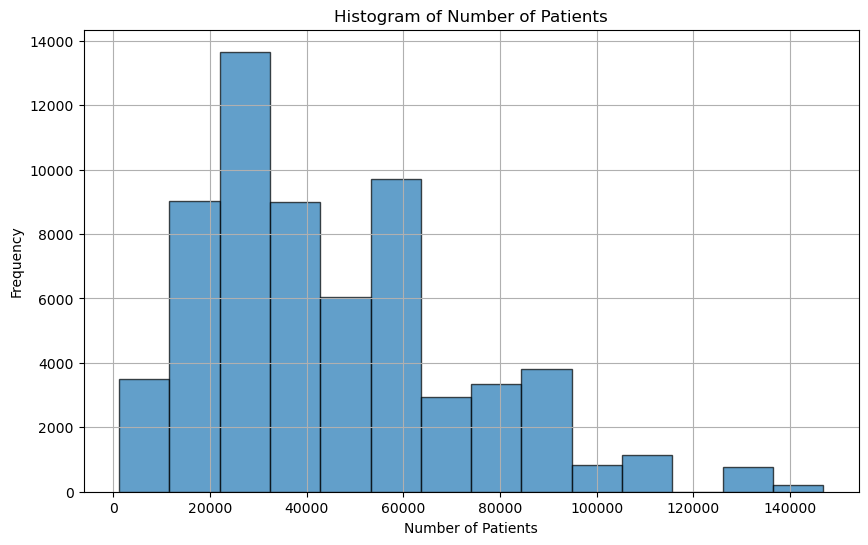

In [62]:
# Creating a histogram
plt.figure(figsize=(10, 6)) 
plt.hist(filtered_data['NUMBER_OF_PATIENTS'], bins=14, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Patients')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Patients')
plt.grid(True)
plt.show()

## Null values

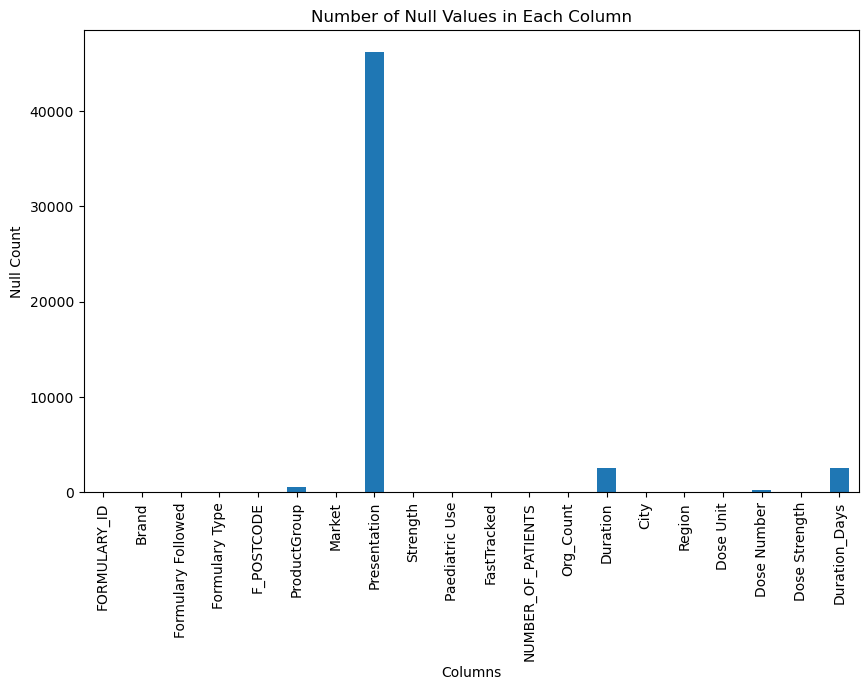

In [63]:
# Calculating the number of null values in each column
null_counts = filtered_data.isnull().sum()

# Creating a bar chart
plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Null Count')
plt.title('Number of Null Values in Each Column')
plt.xticks(rotation=90)
plt.show()

In [64]:
filtered_data.isnull().sum()

FORMULARY_ID              0
Brand                     0
Formulary Followed        0
Formulary Type            0
F_POSTCODE                0
ProductGroup            500
Market                    0
Presentation          46214
Strength                  0
Paediatric Use            0
FastTracked               0
NUMBER_OF_PATIENTS        0
Org_Count                 0
Duration               2515
City                      0
Region                    0
Dose Unit                 0
Dose Number             185
Dose Strength             0
Duration_Days          2515
dtype: int64

In [65]:
filtered_data = filtered_data.dropna(subset=['Duration'])

In [66]:
filtered_data.shape

(61490, 20)

In [67]:
filtered_data.isnull().sum()

FORMULARY_ID              0
Brand                     0
Formulary Followed        0
Formulary Type            0
F_POSTCODE                0
ProductGroup              0
Market                    0
Presentation          44040
Strength                  0
Paediatric Use            0
FastTracked               0
NUMBER_OF_PATIENTS        0
Org_Count                 0
Duration                  0
City                      0
Region                    0
Dose Unit                 0
Dose Number             185
Dose Strength             0
Duration_Days             0
dtype: int64

### Creating Adoption Speed 

In [68]:
filtered_data['adoption_speed'] = np.where(
    ((filtered_data['FastTracked'] == 1) & (filtered_data['Duration_Days'] <= 30)) | 
    ((filtered_data['FastTracked'] == 0) & (filtered_data['Duration_Days'] <= 90)),
    'Fast Adoption', 'Slow Adoption'
)

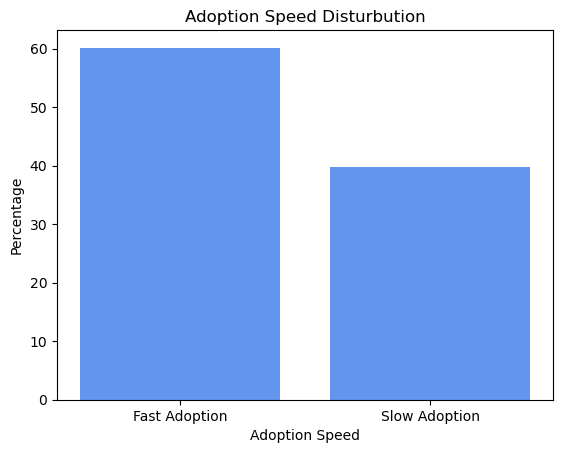

In [69]:
adoption_counts = filtered_data['adoption_speed'].value_counts()
total_data_points = len(filtered_data)

# Converting counts to percentages
adoption_percentages = (adoption_counts / total_data_points) * 100

plt.bar(adoption_percentages.index, adoption_percentages.values, color='cornflowerblue')
plt.xlabel('Adoption Speed')
plt.ylabel('Percentage')
plt.title('Adoption Speed Disturbution')
plt.show()


In [70]:
# Grouping the data by "Formulary ID" and "Market" and counting the number of occurrences for each "Adoption Speed"
grouped_data = filtered_data.groupby(['FORMULARY_ID', 'ProductGroup', 'adoption_speed'])['adoption_speed'].count().unstack(fill_value=0)

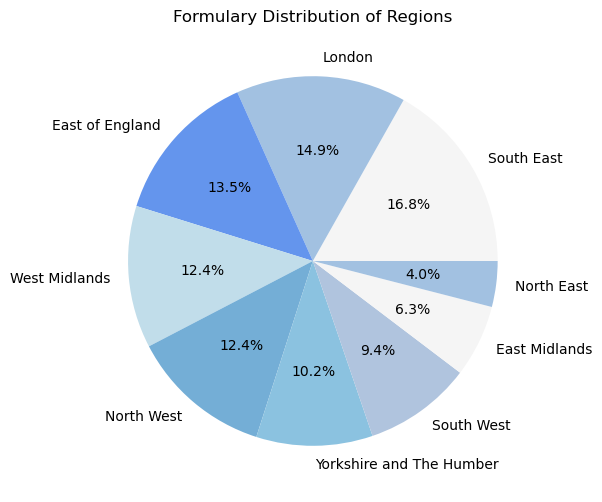

In [71]:
# Counting the number of occurrences of each region
region_counts = filtered_data['Region'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%',colors=['whitesmoke', '#A2C1E1', 'cornflowerblue', '#C1DDEA', '#74AED6', '#8BC2E0', 'lightsteelblue'])
plt.title("Formulary Distribution of Regions")
plt.show()

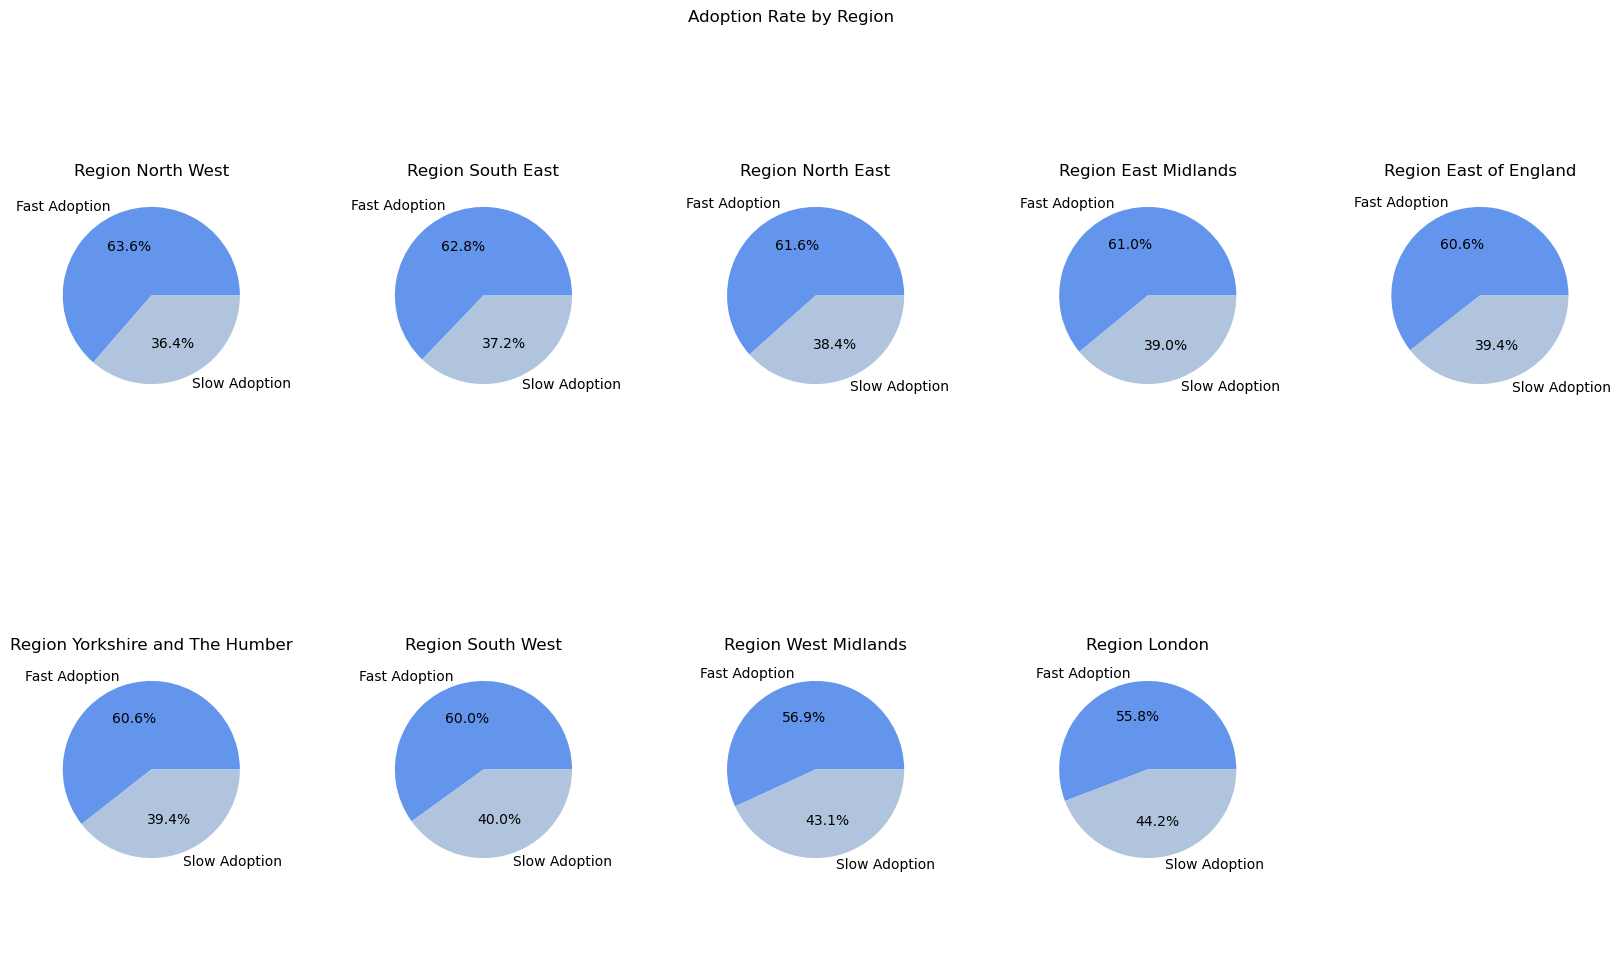

In [72]:
# Calculating the fast adoption percentage for each region
region_fast_adoption = filtered_data[filtered_data['adoption_speed'] == 'Fast Adoption']['Region'].value_counts()
region_total = filtered_data['Region'].value_counts()
region_fast_adoption_percentage = (region_fast_adoption / region_total) * 100

# Calculating the slow adoption percentage for each region
region_slow_adoption = filtered_data[filtered_data['adoption_speed'] == 'Slow Adoption']['Region'].value_counts()
region_slow_adoption_percentage = (region_slow_adoption / region_total) * 100

# Sorting the regions by fast adoption percentage in descending order
sorted_regions = region_fast_adoption_percentage.sort_values(ascending=False)

# Calculate the number of rows and columns for subplots
num_rows = 2
num_cols = (len(sorted_regions) + 1) // num_rows  # Add 1 to make sure we have enough columns

# Creating a new figure and axes for the pie charts
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 11), gridspec_kw={'wspace': 0.5})

# Flattening the axes array for easier iteration
axes = axes.flatten()

# Iterating over each region and plot a pie chart for adoption percentages
for i, (ax, region) in enumerate(zip(axes, sorted_regions.index)):
    region_data = filtered_data[filtered_data['Region'] == region]
    adoption_counts = region_data['adoption_speed'].value_counts()
    ax.pie(adoption_counts, labels=adoption_counts.index, autopct='%1.1f%%', colors=['cornflowerblue', 'lightsteelblue'])
    ax.set_title(f"Region {region}")

# Hiding any empty subplots
for i in range(len(sorted_regions), num_rows * num_cols):
    axes[i].axis('off')

plt.suptitle("Adoption Rate by Region")
plt.subplots_adjust(top=0.9)  # Adjust the spacing between the plots
plt.show()


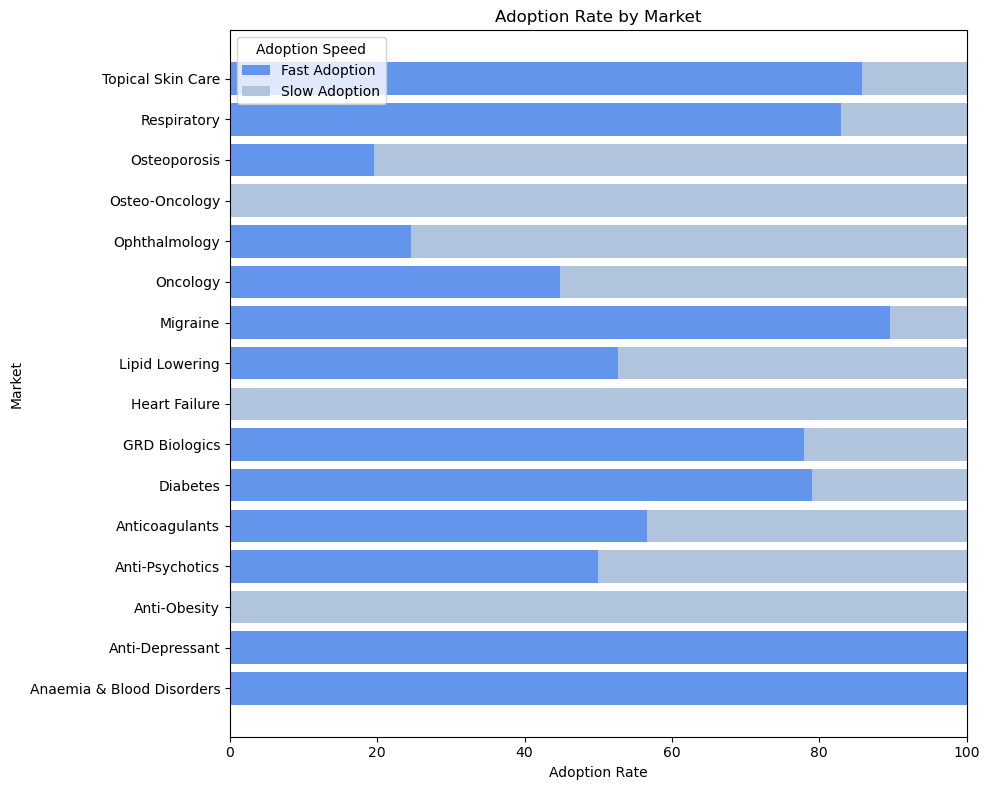

In [73]:
adoption_counts = filtered_data.groupby(['Market', 'adoption_speed']).size().unstack()

# Filling any NaN values with 0
adoption_counts_filled = adoption_counts.fillna(0)
# Calculating the percentage for each row
adoption_percentage = adoption_counts_filled.div(adoption_counts_filled.sum(axis=1), axis=0) * 100

# Resetting the index to convert it to a column
adoption_percentage.reset_index(inplace=True)

# Setting the figure size
plt.figure(figsize=(10, 8))

# Plotting the horizontal stacked bar chart
plt.barh(adoption_percentage['Market'], adoption_percentage['Fast Adoption'], color='cornflowerblue', label='Fast Adoption')
plt.barh(adoption_percentage['Market'], adoption_percentage['Slow Adoption'], color='lightsteelblue', label='Slow Adoption', left=adoption_percentage['Fast Adoption'])

plt.ylabel("Market")
plt.xlabel("Adoption Rate")
plt.title("Adoption Rate by Market")
plt.legend(title='Adoption Speed')
plt.tight_layout()
plt.show()

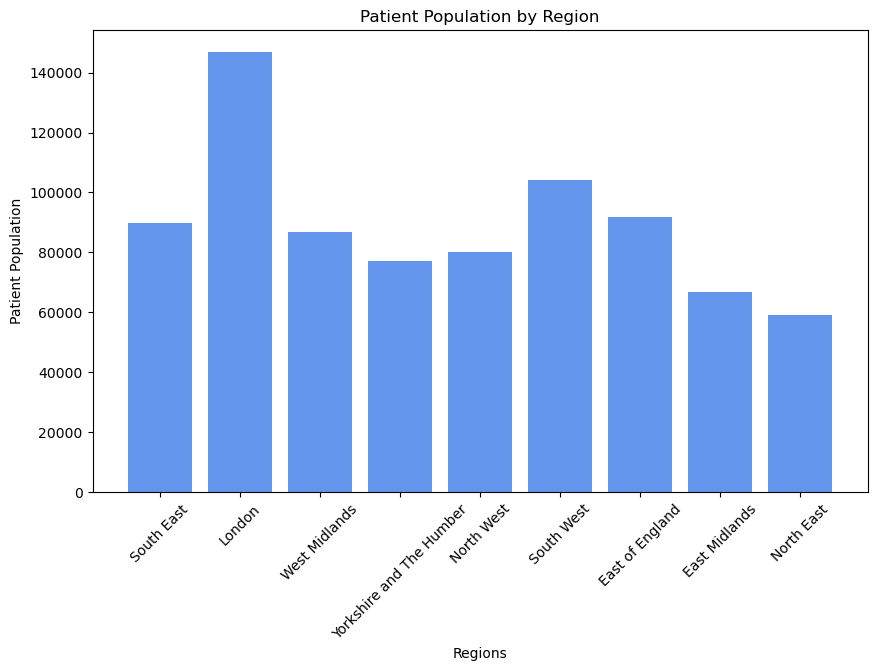

In [74]:
# Creating a scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.bar(filtered_data['Region'], filtered_data['NUMBER_OF_PATIENTS'], color='cornflowerblue')

# Adding labels and title
plt.xlabel('Regions')
plt.ylabel('Patient Population')
plt.title('Patient Population by Region')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

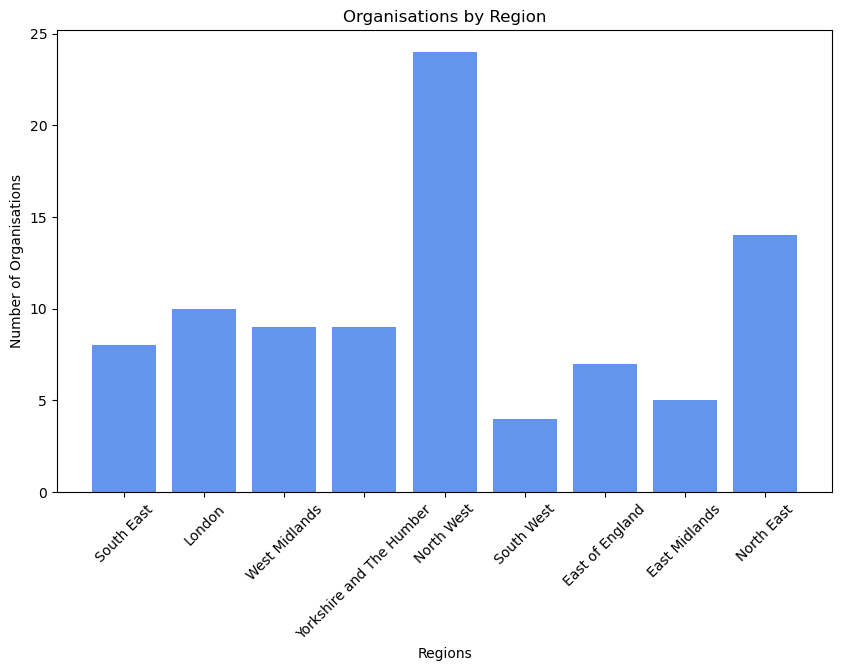

In [75]:
# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.bar(filtered_data['Region'], filtered_data['Org_Count'], color='cornflowerblue')

# Adding labels and title
plt.xlabel('Regions')
plt.ylabel('Number of Organisations')
plt.title('Organisations by Region')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

In [76]:
filtered_data.adoption_speed.unique()

array(['Slow Adoption', 'Fast Adoption'], dtype=object)

### Negative Duration

Negative duration means the drug was in rhe formulary before NICE recommends it

In [77]:
# Counting the negative values in the "Duration" column
negative_count = (filtered_data['Duration'] < timedelta(days=0)).sum()

# Printing the count
print("Number of Negative Values in 'Duration' Column:", negative_count)

Number of Negative Values in 'Duration' Column: 34249


# Data Preparing

### Columns to keep and avoid multicolinearity
- Formulary ID
- Market
- Number of Patients
- Dose Strength
- Region
- Fast Tracked
- Adoption Speed
- Formulary Type
- Organization Count



### Removing Columns

In [78]:
# Dropping the columns not in the list of columns to keep
filtered_data = filtered_data[['FORMULARY_ID','Formulary Type','Org_Count','Region','Market','Dose Strength','NUMBER_OF_PATIENTS','FastTracked','adoption_speed']]

# Data Processing

### One Hot Encoding

In [79]:
#Specifing categorical columns
non_numeric_columns = filtered_data.select_dtypes(exclude=['int', 'float']).columns

In [80]:
df_encoded = pd.get_dummies(filtered_data, columns=non_numeric_columns)

### Checking class imbalance

Class Counts:
Fast Adoption    36999
Slow Adoption    24491
Name: adoption_speed, dtype: int64

Class Proportions:
Fast Adoption    0.601708
Slow Adoption    0.398292
Name: adoption_speed, dtype: float64


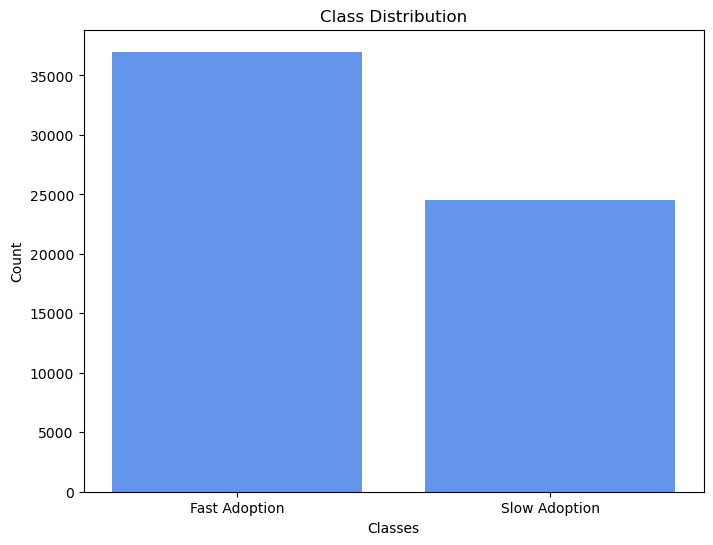

In [81]:
# Counting the occurrences of each class in the target variable
class_counts = filtered_data['adoption_speed'].value_counts()

# Calculating the proportion of each class in the target variable
class_proportions = class_counts / len(filtered_data)

# Printing the class counts and proportions
print("Class Counts:")
print(class_counts)

print("\nClass Proportions:")
print(class_proportions)

# Visualizing the class distribution with a bar plot

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values,color='cornflowerblue')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

The graph shows that the proportions are 60:40 meaning there is no class imbalance.

### Splitting the Data

In [82]:
# Splitting data into features (X) and target (y)
X = df_encoded.drop(['adoption_speed_Fast Adoption','adoption_speed_Slow Adoption'], axis=1)
y = df_encoded['adoption_speed_Fast Adoption']

### Scaling/Standardization

In [83]:
# Standardizing the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [84]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Checking the shape of the train and test sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (49192, 36) (49192,)
Test set shape: (12298, 36) (12298,)


### First Round of Modeling

The code below was used for determining the feature selection model, however, it is commented out as it is not used for modeling.

In [85]:
# Create the decision tree model
#rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training data
#rf_model.fit(X_train, y_train)

# Predictions on training and test sets
#y_train_pred = rf_model.predict(X_train)
#y_test_pred = rf_model.predict(X_test)

# Calculate accuracy scores
#accuracy_train = accuracy_score(y_train, y_train_pred)
#accuracy_test = accuracy_score(y_test, y_test_pred)

# Print accuracy scores
#print("Training Accuracy:", accuracy_train)
#print("Test Accuracy:", accuracy_test)

# Create a line chart to compare training and test scores
#metrics = ['Training Accuracy', 'Test Accuracy']
#scores = [accuracy_train, accuracy_test]
#x = np.arange(len(metrics))

#plt.plot(x, scores, marker='o')
#plt.xlabel('Metrics')
#plt.ylabel('Accuracy')
#plt.title('Training and Test Accuracy Scores')
#plt.xticks(x, metrics)
#plt.grid(True)
#plt.show()
# Evaluate the model on the test set
#accuracy_rf = accuracy_score(y_test, y_test_pred)
#precision_rf = precision_score(y_test, y_test_pred)
#recall_rf = recall_score(y_test, y_test_pred)
#f1_rf = f1_score(y_test, y_test_pred)
#roc_auc_rf = roc_auc_score(y_test, y_test_pred)
#conf_matrix_rf = confusion_matrix(y_test, y_test_pred)

#print("Accuracy:", accuracy_rf)
#print("Precision:", precision_rf)
#print("Recall:", recall_rf)
#print("F1-score:", f1_rf)
#print("ROC AUC Score:", roc_auc_rf)
#print("Confusion Matrix:\n", conf_matrix_rf)

In [86]:
# Create the decision tree model
#xgb_model = XGBClassifier(random_state=42)

# Train the model on the training data
#xgb_model.fit(X_train, y_train)

# Predictions on training and test sets
#y_train_pred = xgb_model.predict(X_train)
#y_test_pred = xgb_model.predict(X_test)

# Calculate accuracy scores
#accuracy_train = accuracy_score(y_train, y_train_pred)
#accuracy_test = accuracy_score(y_test, y_test_pred)

# Print accuracy scores
#print("Training Accuracy:", accuracy_train)
#print("Test Accuracy:", accuracy_test)

# Create a line chart to compare training and test scores
#metrics = ['Training Accuracy', 'Test Accuracy']
#scores = [accuracy_train, accuracy_test]
#x = np.arange(len(metrics))

#plt.plot(x, scores, marker='o')
#plt.xlabel('Metrics')
#plt.ylabel('Accuracy')
#plt.title('Training and Test Accuracy Scores')
#plt.xticks(x, metrics)
#plt.grid(True)
#plt.show()

# Evaluate the model on the test set
#accuracy_xgb = accuracy_score(y_test, y_test_pred)
#precision_xgb = precision_score(y_test, y_test_pred)
#recall_xgb = recall_score(y_test, y_test_pred)
#f1_xgb = f1_score(y_test, y_test_pred)
#roc_auc_xgb = roc_auc_score(y_test, y_test_pred)
#conf_matrix_xgb = confusion_matrix(y_test, y_test_pred)

#print("Accuracy:", accuracy_xgb)
#print("Precision:", precision_xgb)
#print("Recall:", recall_xgb)
#print("F1-score:", f1_xgb)
#print("ROC AUC Score:", roc_auc_xgb)
#print("Confusion Matrix:\n", conf_matrix_xgb)

In [87]:
# Create the decision tree model
#lr_model = LogisticRegression(random_state=42)

# Train the model on the training data
#lr_model.fit(X_train, y_train)

# Predictions on training and test sets
#y_train_pred = lr_model.predict(X_train)
#y_test_pred = lr_model.predict(X_test)

# Calculate accuracy scores
#accuracy_train = accuracy_score(y_train, y_train_pred)
#accuracy_test = accuracy_score(y_test, y_test_pred)

# Print accuracy scores
#print("Training Accuracy:", accuracy_train)
#print("Test Accuracy:", accuracy_test)

# Create a line chart to compare training and test scores
#metrics = ['Training Accuracy', 'Test Accuracy']
#scores = [accuracy_train, accuracy_test]
#x = np.arange(len(metrics))

#plt.plot(x, scores, marker='o')
#plt.xlabel('Metrics')
#plt.ylabel('Accuracy')
#plt.title('Training and Test Accuracy Scores')
#plt.xticks(x, metrics)
#plt.grid(True)
#plt.show()
# Evaluate the model on the test set
#accuracy_lr = accuracy_score(y_test, y_test_pred)
#precision_lr = precision_score(y_test, y_test_pred)
#recall_lr = recall_score(y_test, y_test_pred)
#f1_lr = f1_score(y_test, y_test_pred)
#roc_auc_lr = roc_auc_score(y_test, y_test_pred)
#conf_matrix_lr = confusion_matrix(y_test, y_test_pred)

# Print the evaluation metrics
#print("Accuracy:", accuracy_lr)
#print("Precision:", precision_lr)
#print("Recall:", recall_lr)
#print("F1-score:", f1_lr)
#print("ROC AUC Score:", roc_auc_lr)
#print("Confusion Matrix:")
#print(conf_matrix_lr)

In [88]:
# Create a line chart to compare evaluation metrics for all models
#metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']
#logistic_regression_metrics = [accuracy_lr, precision_lr, recall_lr, f1_lr, roc_auc_lr]
#random_forest_metrics = [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf]
#xgboost_metrics = [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb, roc_auc_xgb]
#svc_metrics = [accuracy_svc, precision_svc, recall_svc, f1_svc, roc_auc_svc]
#x = np.arange(len(metrics))

#plt.plot(x, logistic_regression_metrics, label='Logistic Regression', marker='o')
#plt.plot(x, svc_metrics, label='SVC', marker='o')
#plt.plot(x, random_forest_metrics, label='Random Forest', marker='o')
#plt.plot(x, xgboost_metrics, label='XGBoost', marker='o')
#plt.xlabel('Metrics')
#plt.ylabel('Score')
#plt.title('Comparison of Model Evaluation Metrics')
#plt.xticks(x, metrics)
#plt.legend()
#plt.grid(True)
#plt.ylim(0.0, 1.0)
#plt.show()

### XGboost

In [89]:
# Creating and fit the XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Performing univariate feature selection using chi-square test
selector = SelectKBest(score_func=chi2,k=15)  # Select the top 10 features
X_train_selected = selector.fit_transform(X_train, y_train)
# Getting the feature indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Getting the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

# Training the XGBoost classifier on the selected features
xgb_model_selected = XGBClassifier()
xgb_model_selected.fit(X_train_selected, y_train)

# Evaluating the model on the test set
X_test_selected = X_test[:, selected_feature_indices]
accuracy = xgb_model_selected.score(X_test_selected, y_test)
print("Accuracy on the test set using selected features:", accuracy)

Accuracy on the test set using selected features: 0.6922263782728899


In [90]:
X_train_selected.shape

(49192, 15)

In [91]:
# Making predictions on the test set using the model with selected features
y_pred = xgb_model_selected.predict(X_test_selected)

# Evaluating the model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.6922263782728899
Precision: 0.7558220610793474
Recall: 0.7271263751006172
F1-score: 0.7411965811965813
ROC AUC Score: 0.6828241289210766
Confusion Matrix:
 [[3093 1751]
 [2034 5420]]


In [92]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Best Accuracy: 0.6922
ROC AUC Score: 0.6828


In [93]:
selected_feature_names

Index(['Dose Strength', 'FastTracked', 'Region_London',
       'Market_Anti-Depressant', 'Market_Anti-Obesity', 'Market_Diabetes',
       'Market_GRD Biologics', 'Market_Heart Failure', 'Market_Migraine',
       'Market_Oncology', 'Market_Ophthalmology', 'Market_Osteo-Oncology',
       'Market_Osteoporosis', 'Market_Respiratory',
       'Market_Topical Skin Care'],
      dtype='object')

In [94]:
filtered_data.shape

(61490, 9)

## Evaluation Metrics

### Hyperparameter Tuning 

In [95]:
param_dist = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}

### Random Search

In [96]:
random_search = RandomizedSearchCV(estimator=xgb_model_selected, param_distributions=param_dist, n_iter=20,n_jobs=-1, cv=5, scoring='accuracy')

In [97]:
filtered_data.shape

(61490, 9)

In [98]:
random_search.fit(X_train_selected ,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                

In [99]:
random_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [100]:
random_search.best_estimator_.subsample

0.9

In [101]:
random_search.best_estimator_.reg_alpha

0

In [102]:
random_search.best_estimator_.reg_lambda

0

In [103]:
# Evaluating Model Performance
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Best Accuracy: 0.6922
ROC AUC Score: 0.6828


In [104]:
# Calculating evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred)
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
roc_auc_xgb = roc_auc_score(y_test, y_pred)
conf_matrix_xgb = confusion_matrix(y_test, y_pred)

# Printing the evaluation metrics
print("Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1-score:", f1_xgb)
print("ROC AUC Score:", roc_auc_xgb)
print("Confusion Matrix:")
print(conf_matrix_xgb)

Accuracy: 0.6922263782728899
Precision: 0.7558220610793474
Recall: 0.7271263751006172
F1-score: 0.7411965811965813
ROC AUC Score: 0.6828241289210766
Confusion Matrix:
[[3093 1751]
 [2034 5420]]


## Random Forest

In [105]:
# Traing the Random Forest classifier on the selected features
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_selected, y_train)

# Evaluating the model on the test set
accuracy = rf_model.score(X_test_selected, y_test)
print("Accuracy on the test set using selected features:", accuracy)

Accuracy on the test set using selected features: 0.6922263782728899


In [106]:
# Defining the hyperparameter search space for Random Forest
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}
# Creating the RandomizedSearchCV object with 5-fold cross-validation
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=20, n_jobs=-1, cv=5, scoring='accuracy', random_state=42)

In [107]:
random_search.fit(X_train_selected, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [108]:
# Getting the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 7, 'bootstrap': False}


In [109]:
# Training the Random Forest classifier with the best hyperparameters on the selected features
best_rf_model = RandomForestClassifier(random_state=42, **best_params)
best_rf_model.fit(X_train_selected, y_train)

RandomForestClassifier(bootstrap=False, max_depth=7, min_samples_leaf=2,
                       n_estimators=50, random_state=42)

In [110]:
y_pred = best_rf_model.predict(X_test_selected)
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred)
recall_rf = recall_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)
roc_auc_rf = roc_auc_score(y_test, y_pred)
conf_matrix_rf = confusion_matrix(y_test, y_pred)

# Printing the evaluation metrics
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-score:", f1_rf)
print("ROC AUC Score:", roc_auc_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)

Accuracy: 0.6910066677508538
Precision: 0.74965837660563
Recall: 0.7359806815132814
F1-score: 0.7427565664771189
ROC AUC Score: 0.6788904233330239
Confusion Matrix:
[[3012 1832]
 [1968 5486]]


## Logistic Regression 

In [111]:
# Training the Logistic Regression model on the selected features
lr_model = LogisticRegression()

Hyperparameter tuning 

In [112]:
# Defining the hyperparameter search space for Logistic Regression
param_dist = {
    'penalty': ['l1', 'l2'], 
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],  # Use 'liblinear' or 'saga' solver
    'max_iter': [1000, 2000, 5000],  # Increase max_iter
}

In [113]:
# Creating the RandomizedSearchCV object with 5-fold cross-validation
random_search = RandomizedSearchCV(lr_model, param_distributions=param_dist, n_iter=5, n_jobs=-1, cv=5,error_score='raise', scoring='accuracy', random_state=42)

In [114]:
random_search.fit(X_train_selected, y_train)

RandomizedSearchCV(cv=5, error_score='raise', estimator=LogisticRegression(),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'max_iter': [1000, 2000, 5000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, scoring='accuracy')

In [115]:
# Getting the best hyperparameters
best_params = random_search.best_params_
# Training the Logistic Regression model with the best hyperparameters on the selected features
best_lr_model = LogisticRegression(random_state=42, **best_params)
best_lr_model.fit(X_train_selected, y_train)

LogisticRegression(C=100, max_iter=1000, random_state=42, solver='liblinear')

In [116]:
random_search.best_estimator_.penalty

'l2'

In [117]:
# Evaluating the model on the test set
y_pred = best_lr_model.predict(X_test_selected)

In [118]:
# Calculating evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred)
precision_lr = precision_score(y_test, y_pred)
recall_lr = recall_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred)
roc_auc_lr = roc_auc_score(y_test, y_pred)
conf_matrix_lr = confusion_matrix(y_test, y_pred)

# Printing the evaluation metrics
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1-score:", f1_lr)
print("ROC AUC Score:", roc_auc_lr)
print("Confusion Matrix:")
print(conf_matrix_lr)

Accuracy: 0.6877541063587576
Precision: 0.7560215358458486
Recall: 0.7158572578481353
F1-score: 0.7353914002205072
ROC AUC Score: 0.6801829641841832
Confusion Matrix:
[[3122 1722]
 [2118 5336]]


## Model Evaluation

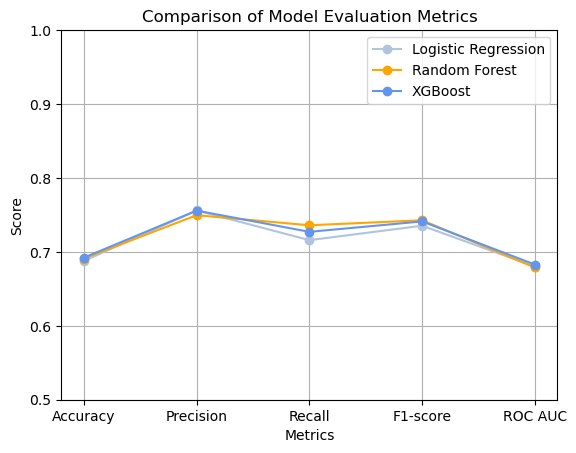

In [119]:
# Creating a bar plot to compare evaluation metrics for all models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']
logistic_regression_metrics = [accuracy_lr, precision_lr, recall_lr, f1_lr, roc_auc_lr]
random_forest_metrics = [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf]
xgboost_metrics = [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb, roc_auc_xgb]

x = np.arange(len(metrics))

plt.plot(x, logistic_regression_metrics, label='Logistic Regression', marker='o',color='lightsteelblue')
plt.plot(x, random_forest_metrics, label='Random Forest', marker='o',color='orange')
plt.plot(x, xgboost_metrics, label='XGBoost', marker='o',color='cornflowerblue')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Comparison of Model Evaluation Metrics')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True)
plt.ylim(0.5, 1.0)
plt.show()

### Detailed Comparison

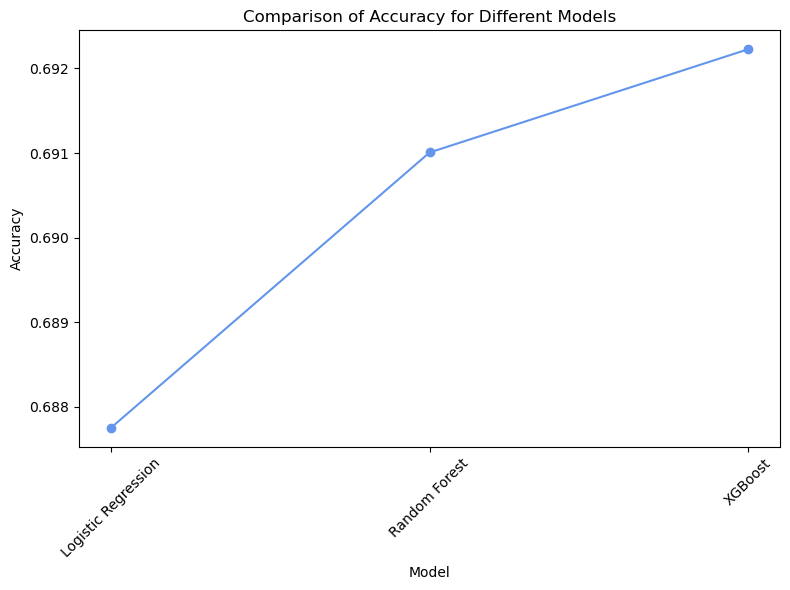

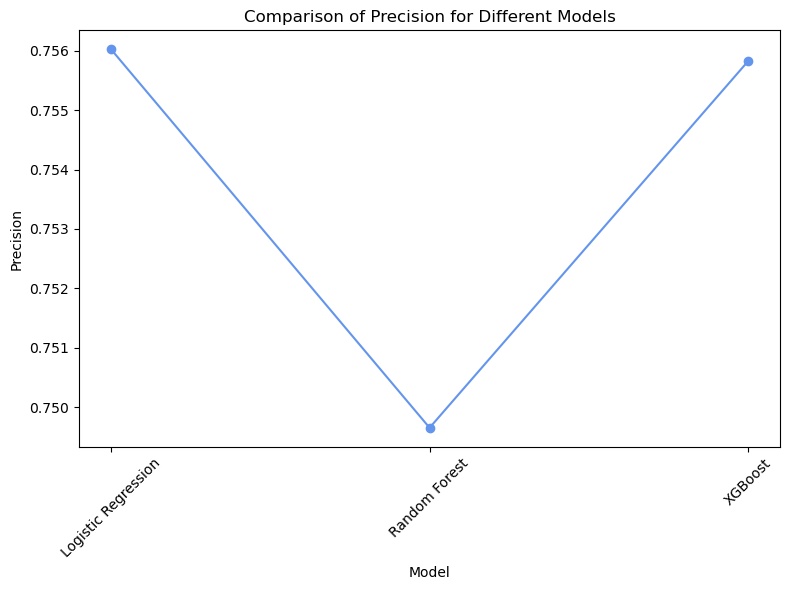

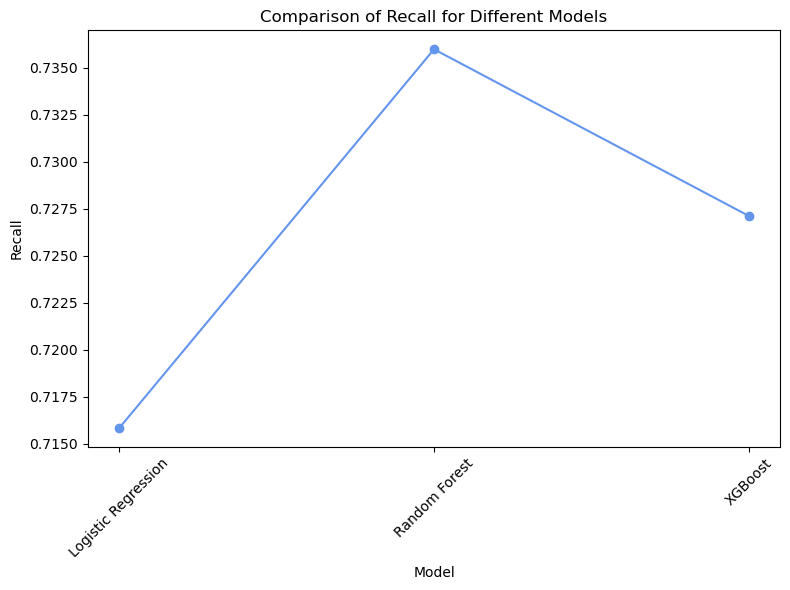

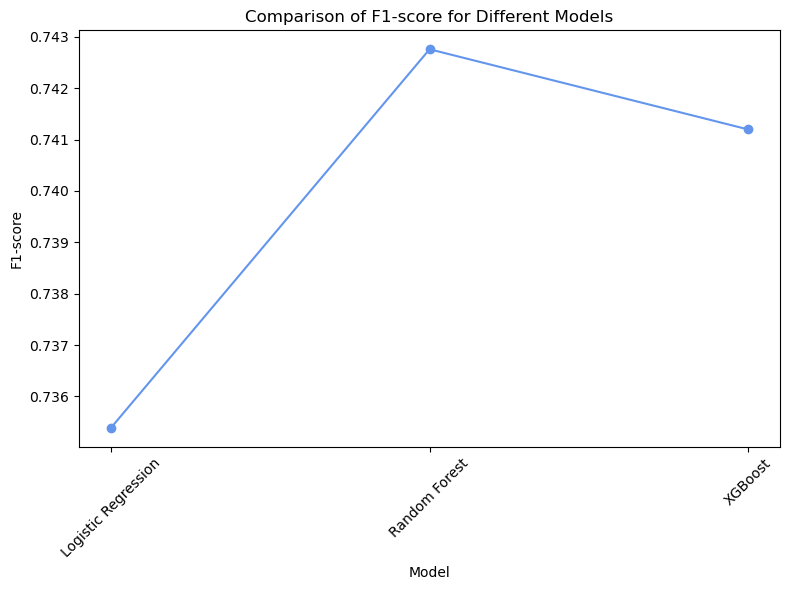

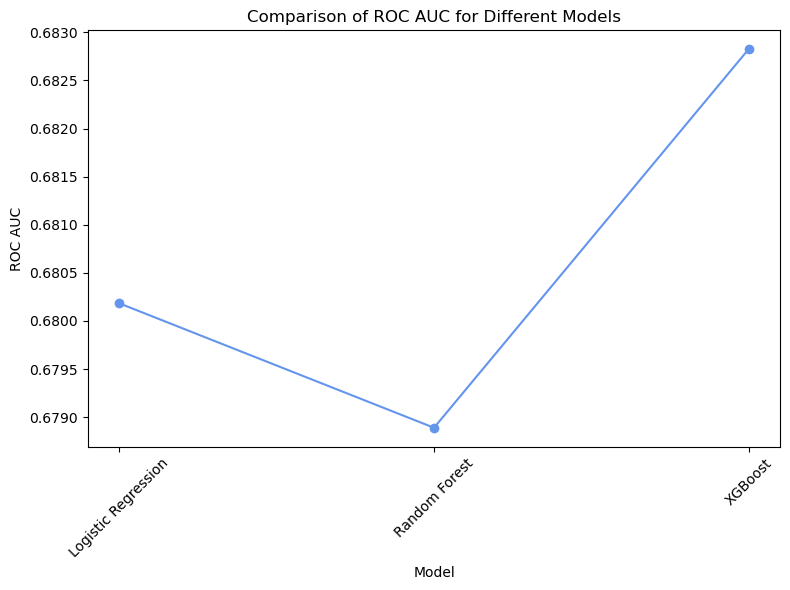

In [120]:
# Creating a pandas DataFrame to organize the metrics data
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_xgb],
    'Precision': [precision_lr, precision_rf, precision_xgb],
    'Recall': [recall_lr, recall_rf, recall_xgb],
    'F1-score': [f1_lr, f1_rf, f1_xgb],
    'ROC AUC': [roc_auc_lr, roc_auc_rf, roc_auc_xgb]
}

df_metrics = pd.DataFrame(data)

# Plotting each evaluation metric in a separate graph as a line chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']

for metric in metrics:
    plt.figure(figsize=(8, 6))
    plt.plot(df_metrics['Model'], df_metrics[metric], marker='o', linestyle='-',color='cornflowerblue')
    plt.title(f'Comparison of {metric} for Different Models')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Confusion Matrix

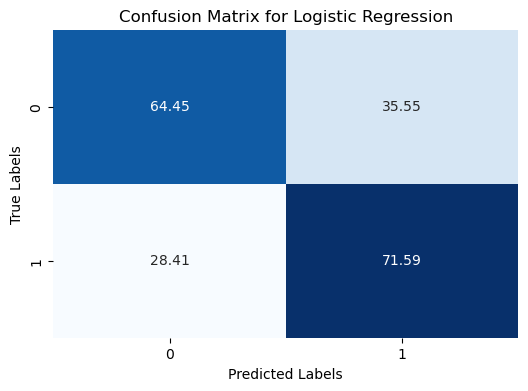

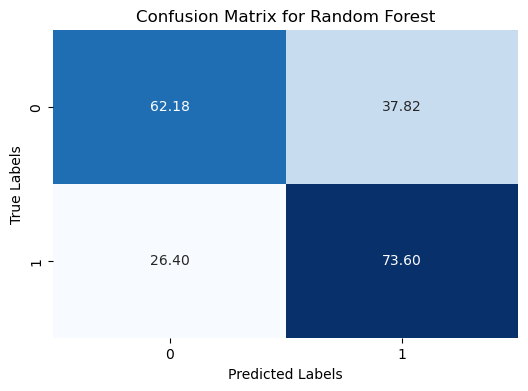

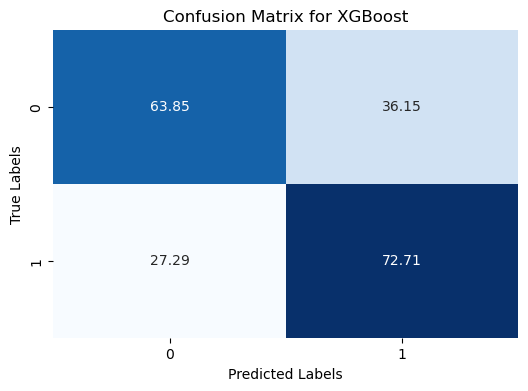

In [121]:
def plot_confusion_matrix(model_name, cm):
    plt.figure(figsize=(6, 4))

    # Calculate row-wise sums (actual class counts) and column-wise sums (predicted class counts)
    row_sums = cm.sum(axis=1, keepdims=True)
    col_sums = cm.sum(axis=0, keepdims=True)

    # Calculate the percentages for each cell in the confusion matrix
    percentages = cm / row_sums * 100

    sns.heatmap(percentages, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot the confusion matrices for each model
plot_confusion_matrix('Logistic Regression', conf_matrix_lr)
plot_confusion_matrix('Random Forest', conf_matrix_rf)
plot_confusion_matrix('XGBoost', conf_matrix_xgb)


## Model Interpretation

### Selected Features

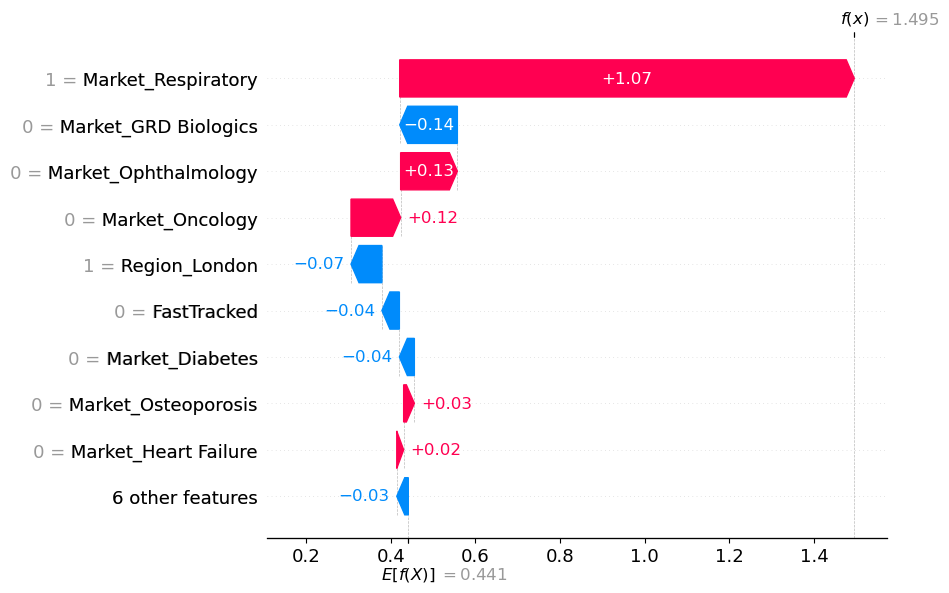

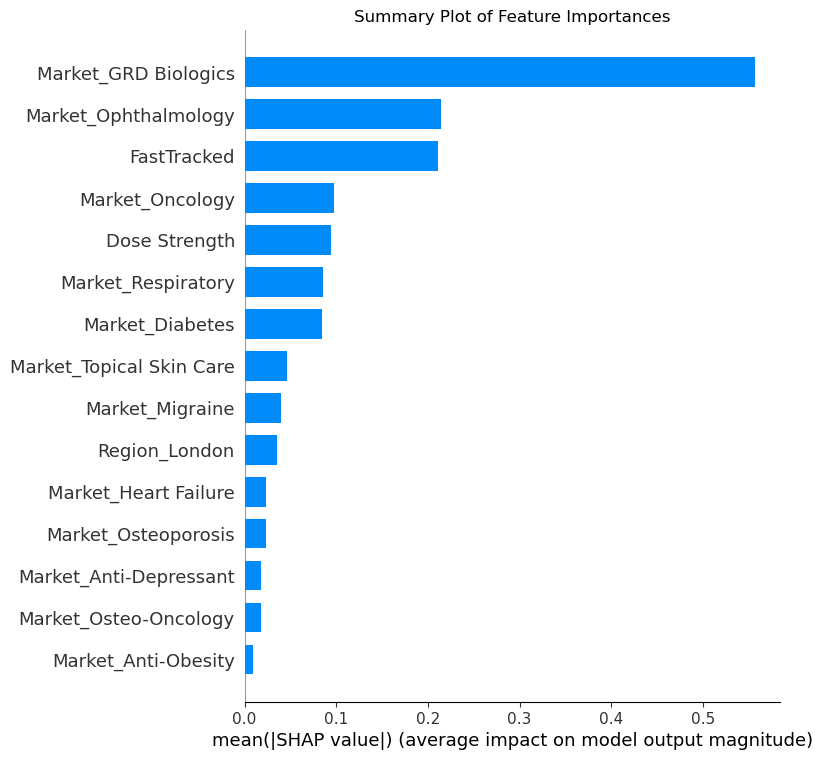

In [122]:
# Converting X_test to a DataFrame
X_test_df = pd.DataFrame(X_test_selected, columns=selected_feature_names)

explainer = shap.Explainer(xgb_model_selected)
shap_values = explainer(X_test_df)
# Ploting the SHAP values for a specific prediction (e.g., the first instance in the test set)
shap.initjs()
shap.waterfall_plot(shap_values[0], max_display=10)  # Adjust max_display as needed

# Plotting the summary plot of feature importances for the entire test set
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
plt.title("Summary Plot of Feature Importances")
plt.show()

### All Features

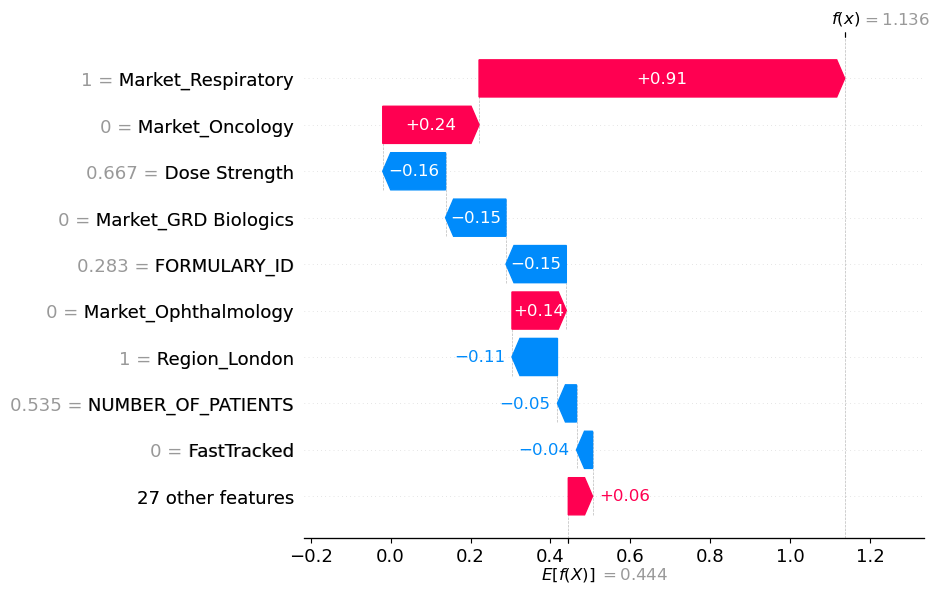

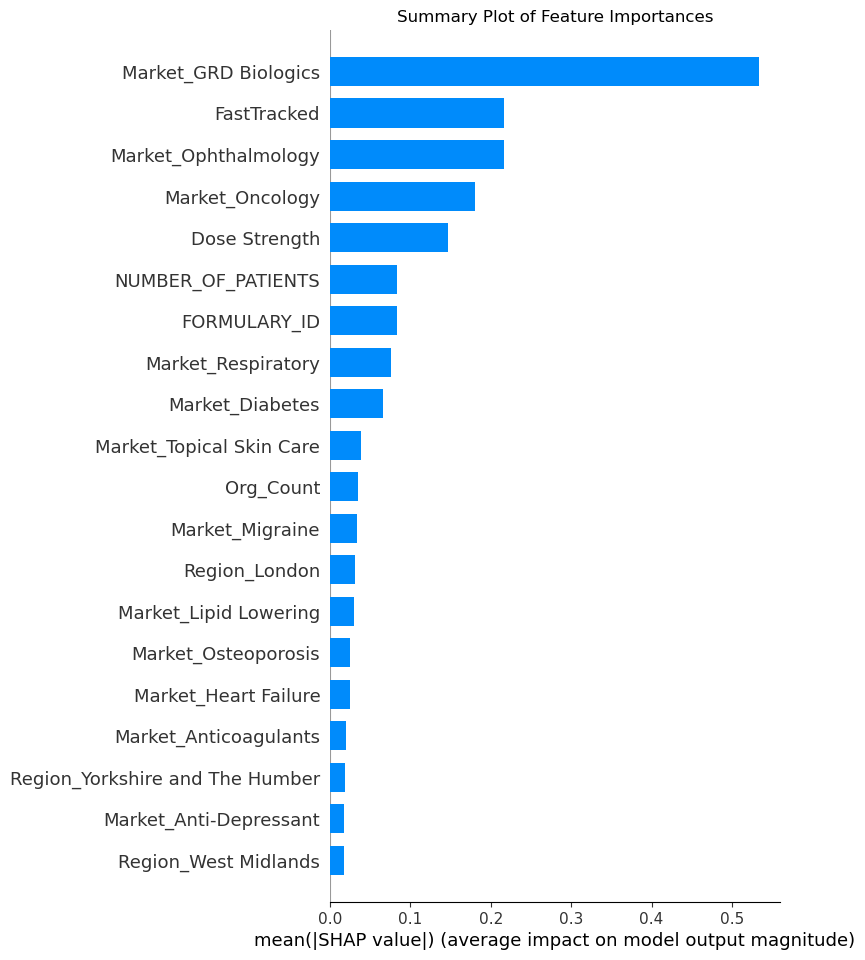

In [123]:
# Convert X_test to a DataFrame
X_test_df = pd.DataFrame(X_test, columns=X.columns)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_df)
# Plot the SHAP values for a specific prediction (e.g., the first instance in the test set)
shap.initjs()
shap.waterfall_plot(shap_values[0], max_display=10)  # Adjust max_display as needed

# Plot the summary plot of feature importances for the entire test set
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
plt.title("Summary Plot of Feature Importances")
plt.show()